時系列変化を動画で見る。

In [1]:
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import re
from matplotlib import pyplot as plt
import matplotlib.animation

In [2]:
# nib のセルのいくつかは数値に補足情報が付いているので、除去する
def drop_notes(c):
    if c is not None and len(c):
        m = re.match(r'^(\d+)\s*[（\()]内地域枠\d+[）\)]$', c)
        if m:
            return int(m.group(1))
        elif c[-1] in "*＊":
            return int(c[:-1])
        else:
            return int(c)
    return None

#"状況,利用定員（２・３号）"は本園に合算されているので使わない
k1 = ["状況,合計", "１号,認可定員(全体)", "２号３号,利用定員（2・3号）"]
k2 = ["状況,申込児童数 %s歳児" % "０１２３４５"[i] for i in range(6)]
k3 = ["%d歳" % i for i in range(6)]

def load_zensi(fname):
    e = pd.ExcelFile(fname)
    opts = dict(skiprows=1, converters={"区コード":str, "町コード":str})
    dfs = [e.parse(s, **opts).iloc[1:,:] for s in e.sheet_names if s != "神戸市"]
    return gpd.GeoDataFrame(pd.concat(dfs, ignore_index=True))

titles = ["2016-%d" % i for i in range(5,10)]
fns = (
    ("../data/hkwi/shinseido-2016-05.json","../data/kobe/zensi2805.xls"),
    ("../data/hkwi/shinseido-2016-06.json","../data/kobe/zensi2805.xls"),
    ("../data/hkwi/shinseido-2016-07.json","../data/kobe/zensi2806.xls"),
    ("../data/hkwi/shinseido-2016-08.json","../data/kobe/zensi2807.xls"),
    ("../data/hkwi/shinseido-2016-09.json","../data/kobe/zensi2808.xls"),
)

In [3]:
%matplotlib inline

ざっくりとした概略では、0歳だけがひたすら伸びていることが見て取れる。

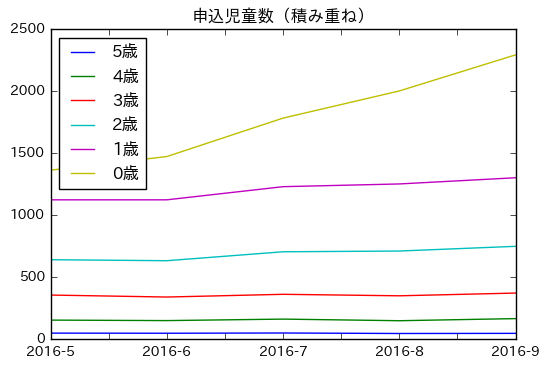

In [4]:
fibs = {}
for i,fn in enumerate(fns):
    shinseido,zensi = fn
    fib_ = gpd.read_file(shinseido)
    fib = fib_[fib_["状況,参照"]!="本園"].assign(
        **{k:fib_[k].apply(drop_notes) for k in k2}
    )
    fibs["2016-%d" % (i+5)] = fib[k2].sum().rename(dict(zip(k2,k3)))

ax = pd.DataFrame(fibs, index=reversed(k3)).T.plot(stacked=True)
_ = ax.set_title("申込児童数（積み重ね）")

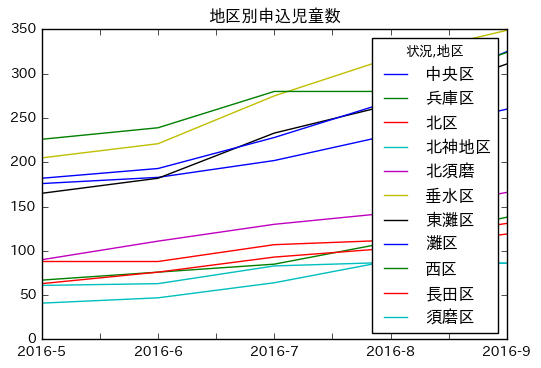

In [5]:
fibs = {}
for i,fn in enumerate(fns):
    shinseido,zensi = fn
    fib_ = gpd.read_file(shinseido)
    fib = fib_[fib_["状況,参照"]!="本園"].assign(
        **{k:fib_[k].apply(drop_notes) for k in k1}
    )
    fibs["2016-%d" % (i+5)] = fib.groupby("状況,地区").sum()["状況,合計"]

ax = pd.DataFrame(fibs).T.plot()
_ = ax.set_title("地区別申込児童数")

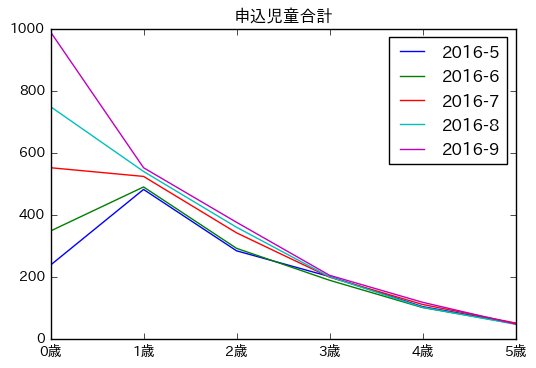

In [6]:
fibs = {}
for i,fn in enumerate(fns):
    shinseido,zensi = fn
    fib_ = gpd.read_file(shinseido)
    fib = fib_[fib_["状況,参照"]!="本園"].assign(
        **{k:fib_[k].apply(drop_notes) for k in k2}
    )
    fibs["2016-%d" % (i+5)] = fib[k2].sum().rename(dict(zip(k2,k3)))

ax = pd.DataFrame(fibs, index=k3).plot()
_ = ax.set_title("申込児童合計")

In [7]:
class Proc(object):
    def __init__(self, shinseido, zensi):
        self.data = {}
        
        nib_ = gpd.read_file(shinseido)
        nib = nib_[nib_["状況,参照"]!="本園"] # そのまま集計すると、分園の数だけ二重に集計してしまう
        nib_ = nib[k1+k2].applymap(drop_notes)
        nib = nib.assign(**{k:nib_[k] for k in k1+k2})

        zib = load_zensi(zensi)
        r0 = nib.sum().rename(index=dict(zip(k2,k3)))/zib.sum()
        d0 = nib.groupby("状況,地区").sum()
        d1 = zib.groupby("区・支所").sum().rename(index={"北須磨支所":"北須磨"})
        nib2 = nib.groupby("状況,地区").sum()
        nib2.loc["北区",:] += nib2.loc["北神地区",:]
        nib3 = nib2.loc[[i for i in nib2.index if i!="北神地区"],:].rename(columns=dict(zip(k2,k3)))
        d2 = (nib3/d1)[k3]
        r1 = d2/r0

        self.data["申込数"] = nib3[k3]
        self.data["倍率"] = r1[k3]

p = [Proc(*fn) for fn in fns]

In [8]:
%matplotlib nbagg

In [9]:
%matplotlib nbagg

<IPython.core.display.Javascript object>


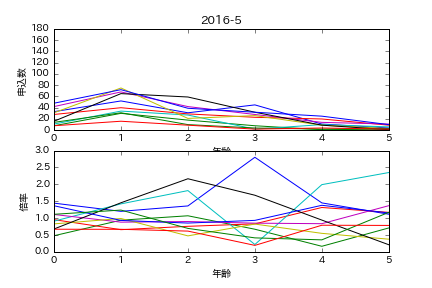

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1)
lines1 = ax1.plot(p[-1].data["申込数"].T.values)
ax1.set_xlabel("年齢")
ax1.set_ylabel("申込数")
lines2 = ax2.plot(p[-1].data["倍率"].T.values)
ax2.set_xlabel("年齢")
ax2.set_ylabel("倍率")

def update(t):
    i = t//30
    ax1.title.set_text(titles[i])
    for d,line in zip(p[i].data["申込数"].values, lines1):
        line.set_ydata(d)
    for d,line in zip(p[i].data["倍率"].values, lines2):
        line.set_ydata(d)

ani = matplotlib.animation.FuncAnimation(fig, update, frames=range(30*len(fns)), interval=1000/30, repeat_delay=1000)
plt.show()

In [11]:
Writer = matplotlib.animation.writers["ffmpeg"]
ani.save("../docs/data/2016-10-05-preschool-waits-by-region.mp4",
    writer=Writer(fps=30, codec="libx264", bitrate=1800,
    extra_args=["-profile:v", "baseline", "-pix_fmt","yuv420p"]))